# Imports

In [1]:
!gdown https://drive.google.com/uc?id=1JiZ4Q791pF-7a85gMea-gfVVcajWg6HD


Downloading...
From: https://drive.google.com/uc?id=1JiZ4Q791pF-7a85gMea-gfVVcajWg6HD
To: /content/KazanExpress_Hiring_Task_Junior_DS.zip
3.66MB [00:00, 117MB/s]


In [2]:
!unzip KazanExpress_Hiring_Task_Junior_DS.zip

Archive:  KazanExpress_Hiring_Task_Junior_DS.zip
  inflating: README.md               
   creating: data/
  inflating: data/categories.csv     
  inflating: data/products.csv       


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from gensim.models import Word2Vec

# from catboost import CatBoostClassifier

#text processing
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
cat = pd.read_csv('/content/data/categories.csv')
prod = pd.read_csv('/content/data/products.csv')

# Data

Количесво классов

In [6]:
len(prod.category_id.unique())

787

In [7]:
category_dict = {}
for index, row in cat.iterrows():
    category_id = row['category_path'].split('.')[-1]
    category_dict[int(category_id)] = row['category_path']

In [8]:
prod['full_category'] = prod['category_id'].apply(lambda cat_id: category_dict[cat_id])

In [9]:
prod['category_1'] = prod.full_category.apply(lambda full_cat: full_cat.split('.')[0])
prod['category_2'] = prod.full_category.apply(lambda full_cat: full_cat.split('.')[1])
prod['category_3'] = prod.full_category.apply(lambda full_cat: full_cat.split('.')[2])
prod['category_4'] = prod.full_category.apply(lambda full_cat: full_cat.split('.')[3])

In [10]:
def preprocess_text(text):
    """Preprocess text into normalised tokens."""
    stop_word_list = nltk.corpus.stopwords.words('russian')
    tokeniser = RegexpTokenizer("[A-Za-zА-Яа-я]+")
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise
    # morph = pymorphy2.MorphAnalyzer()
    # tokens_norm = [morph.parse(t.lower())[0].normal_form for t in tokens]
    # tokens_clean = [t for t in tokens_norm if t not in stop_word_list]
    tokens_lower = [t.lower() for t in tokens]
    tokens_clean = [t for t in tokens_lower if t not in stop_word_list]
    return ' '.join(tokens_clean)

In [11]:
prod['preprocessed'] = prod['product_title'].apply(preprocess_text)

In [12]:
prod.head()

,row_number,product_title,category_id,full_category,category_1,category_2,category_3,category_4,preprocessed
0,1,Термокружка с животными 350/500 мл,12407,1.10018.10115.10586.12407,1,10018,10115,10586,термокружка животными мл
1,2,Пластиковая емкость для хранения круп,12667,1.10018.10115.10992.12667,1,10018,10115,10992,пластиковая емкость хранения круп
2,3,Контейнер с дозатором для хранения круп,13901,1.10018.10115.10992.13901,1,10018,10115,10992,контейнер дозатором хранения круп
3,4,Контейнер для хранения яиц,13674,1.10018.10115.10992.13674,1,10018,10115,10992,контейнер хранения яиц
4,5,Губкодержатель,13254,1.10018.10115.10390.13254,1,10018,10115,10390,губкодержатель


#Models

In [36]:
seed = 42
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('sgd', SGDClassifier(random_state=seed)))
    # models.append(('mnb', MultinomialNB()))
    # models.append(('random forest', RandomForestClassifier()))
    # models.append(('catboost', CatBoostClassifier()))
    return models
def assess(X, y, models, cv=5, scoring=['accuracy', 'f1_macro', 'f1_weighted']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [37]:
models = create_baseline_models()
models

[('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='hinge',
                max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
                power_t=0.5, random_state=42, shuffle=True, tol=0.001,
                validation_fraction=0.1, verbose=0, warm_start=False))]

# Категории второго уровня

Примерно сбалансированные классы

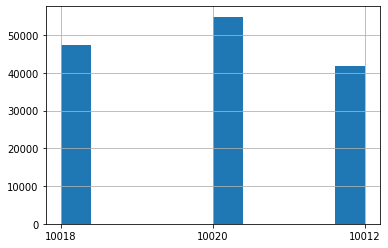

In [15]:
prod.category_2.hist()

## Feature generagion

word to vec: dim 100

In [42]:
w2v_model = Word2Vec(min_count=5,
                     window=2,
                     size=50,
                     sample=6e-5,
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     seed=seed)

w2v_model.build_vocab(prod['preprocessed'].apply(lambda x: x.split()), progress_per=1000)
w2v_model.train(prod['preprocessed'].apply(lambda x: x.split()), total_examples=w2v_model.corpus_count, epochs=60, report_delay=1)
w2v_model.wv.most_similar(positive=["кружка"])

[('сувенирная', 0.7819908261299133),
 ('ъуъ', 0.7343651652336121),
 ('горячо', 0.7322636842727661),
 ('матурым', 0.7287852168083191),
 ('дайте', 0.7258269190788269),
 ('кадерле', 0.692595362663269),
 ('энием', 0.674737274646759),
 ('пивная', 0.672980546951294),
 ('рюмка', 0.6684386134147644),
 ('принтом', 0.662740170955658)]

Усредняем векторы word2veс и получаем вектор предожения

In [43]:
sent_emb = prod['preprocessed'].apply(
    lambda text:
        np.mean([w2v_model.wv[w] for w in text.split() if w in w2v_model.wv],
                axis=0)
              )
y = prod['category_2'][sent_emb.notna()]
X = sent_emb[sent_emb.notna()]
X = np.stack(X)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [44]:
X.shape

(143994, 50)

In [45]:
# vectoriser = TfidfVectorizer(token_pattern=r'[A-Za-zА-Яа-я]+', 
#                              min_df=30)
# X_train_tfidf = vectoriser.fit_transform(prod['product_title'])

## Средняя accuracy по кросс валидации ~ 0.96

In [46]:
%time
results = assess(X, y, models)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [47]:
results.iloc[4:]

,sgd
test_accuracy_mean,0.958609
test_accuracy_std,0.003656
test_f1_macro_mean,0.957147
test_f1_macro_std,0.003669
test_f1_weighted_mean,0.958614
test_f1_weighted_std,0.003651


# Категории третьего уровня

Так как классы не сбалансированные, лучше смотреть на метрики f1

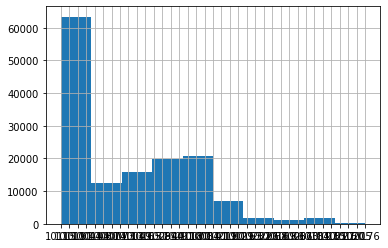

In [48]:
prod.category_3.hist()

In [49]:
len(prod.category_3.unique())

37

In [50]:
y = prod['category_3'][sent_emb.notna()]

##Средняя accuracy по кросс валидации ~ 0.86 & f1_weighted ~ 0.83

In [51]:
%time
results = assess(X, y, models)

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 24.1 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [52]:
results.iloc[4:]

,sgd
test_accuracy_mean,0.842007
test_accuracy_std,0.005717
test_f1_macro_mean,0.579568
test_f1_macro_std,0.009437
test_f1_weighted_mean,0.834853
test_f1_weighted_std,0.005871


## Проверка гипотизы: "Правильное предсказание более высокого уровня поможет при предсказании нижнего"

Добавим категории второго уровня в признаки при предсказании третьего

In [53]:
level2_categories = prod[sent_emb.notna()].category_2.values

In [54]:
level2_categories

array(['10018', '10018', '10018', ..., '10020', '10018', '10020'],
      dtype=object)

In [55]:
y

0         10115
1         10115
2         10115
3         10115
4         10115
          ...  
144077    10113
144078    10044
144079    10044
144080    10049
144081    10044
Name: category_3, Length: 143994, dtype: object

In [56]:
level2_categories = level2_categories.reshape(-1, 1)

In [57]:
extended_X = np.hstack([X, level2_categories])

## accuracy 

In [58]:
%time
results = assess(StandardScaler().fit_transform(extended_X), y, models)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 40.8 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [59]:
results.iloc[4:]

,sgd
test_accuracy_mean,0.845987
test_accuracy_std,0.004297
test_f1_macro_mean,0.567095
test_f1_macro_std,0.009733
test_f1_weighted_mean,0.839836
test_f1_weighted_std,0.003585


## catboost

In [30]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 31 kB/s 


In [ ]:
from catboost import Pool, CatBoostClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(extended_X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

cat_features = [50]




train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=cat_features)

# Initialize CatBoostClassifier
model = CatBoostClassifier(
                           learning_rate=0.1,
                           depth=2,
                           loss_function='MultiClass',
                           custom_metric='TotalF1',
                           eval_metric='TotalF1')
# Fit model
model.fit(train_dataset, eval_set=eval_dataset)
# Get predicted classes


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.2568505	test: 0.2557520	best: 0.2557520 (0)	total: 3.64s	remaining: 1h 33s
1:	learn: 0.2583980	test: 0.2571182	best: 0.2571182 (1)	total: 7.17s	remaining: 59m 39s
2:	learn: 0.2840051	test: 0.2825238	best: 0.2825238 (2)	total: 10.8s	remaining: 59m 34s
3:	learn: 0.3440121	test: 0.3408622	best: 0.3408622 (3)	total: 14.2s	remaining: 59m 1s
4:	learn: 0.3441816	test: 0.3419900	best: 0.3419900 (4)	total: 17.7s	remaining: 58m 40s
5:	learn: 0.3829942	test: 0.3797354	best: 0.3797354 (5)	total: 21.2s	remaining: 58m 35s
6:	learn: 0.3896082	test: 0.3871772	best: 0.3871772 (6)	total: 23.8s	remaining: 56m 11s
7:	learn: 0.3948577	test: 0.3920409	best: 0.3920409 (7)	total: 26.3s	remaining: 54m 19s
8:	learn: 0.4033134	test: 0.4000998	best: 0.4000998 (8)	total: 28.8s	remaining: 52m 56s
9:	learn: 0.4086393	test: 0.4065744	best: 0.4065744 (9)	total: 31.4s	remaining: 51m 49s
10:	learn: 0.4192479	test: 0.4171938	best: 0.4171938 (10)	total: 34s	remaining: 50m 54s
11:	learn: 0.4245842	test: 0.42302

# идеи

Можно попробовать


*   Нагенерировать признаки трансформерными сетками (например Bertом), fasttextом и объеденить с признаками  w2v. 

*   Использовать разные классификаторы, но даже sgdclassifier дает неплохой результат без подбора гиперпараметров.

*   Подобрать гиперпараметры
*   Использовать полученные результаты предсказаний высоких уровней для предсказания более низких




